This notebook presents my completion of lab1 of Berkeley's CS110x course on edx.org. 
I redid all the steps of the analysis that were in the lab assignment here using Python's `sklearn`, `pandas` and other modules.
Please, see [this link](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3752099036319818/819732277501504/6846296372878166/latest.html) for my completion of the lab in the Databricks environment using Spark (some sql and PySpark module).

#### All the necessary module imports:

In [1]:
import pandas as pd
import numpy as np
import requests 
from zipfile import ZipFile 
import io
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor

matplotlib.style.use('ggplot')

#### Load the dataset from the UCI archive:
It's a zipped folder named _CCPP_ and contains the data in an excel file with xlsx format split into 5 sheets. I load it using pd.read_excel:

In [2]:
request = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip')
zipfile = ZipFile(io.BytesIO(request.content))
df = pd.read_excel(zipfile.open('CCPP/Folds5x2_pp.xlsx'), sheetname=None)

We get a dictionary of 5 DataFrames. Let's print out the type and length of df to confirm:

In [3]:
print(type(df))
print(len(df))

<class 'dict'>
5


We can check the names and verify that the dictionary contains DataFrames:

In [4]:
for key in df.keys():
    print(key, ' - ', type(df[key]))

Sheet3  -  <class 'pandas.core.frame.DataFrame'>
Sheet5  -  <class 'pandas.core.frame.DataFrame'>
Sheet2  -  <class 'pandas.core.frame.DataFrame'>
Sheet4  -  <class 'pandas.core.frame.DataFrame'>
Sheet1  -  <class 'pandas.core.frame.DataFrame'>


Next, I create a single DataFrame by stacking the abovementioned 5 DataFrames together:

In [5]:
df2 = pd.DataFrame(np.vstack((df[key] for key in df.keys())), columns=df['Sheet1'].columns)

Let's check the total number of observations in the new dataset and print out the top and bottom 5 observations:

In [6]:
print('The total number of observations is: {}'.format(len(df2)))
print()
print(df2.head())
print()
print(df2.tail())

The total number of observations is: 47840

      AT      V       AP     RH      PE
0   9.44  40.00  1015.62  81.16  471.32
1  23.49  49.30  1003.35  77.96  442.76
2   4.99  39.04  1020.45  78.89  472.52
3  18.24  58.46  1017.38  86.92  449.63
4  27.49  63.78  1015.43  47.45  445.66

          AT      V       AP     RH      PE
47835  16.65  49.69  1014.01  91.00  460.03
47836  13.19  39.18  1023.67  66.78  469.62
47837  31.32  74.33  1012.92  36.48  429.57
47838  24.48  69.45  1013.86  62.39  435.74
47839  21.60  62.52  1017.23  67.87  453.28


Below we can see some descriptive information for the data:

In [7]:
df2.describe()

,AT,V,AP,RH,PE
count,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452162,12.707362,5.938535,14.599658,17.066281
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


Let's graph the __Power Output__ (__PE__), which we're trying to predict, against the predictors:

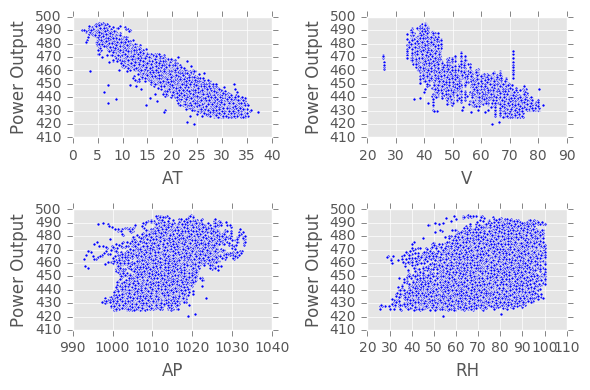

In [8]:
plt.clf()
plt.figure(1, size=(9, 15))
for subplot, col in zip(range(221, 225), df2.columns):
    plt.subplot(subplot)
    plt.scatter(df2[col], df2['PE'], marker='.')
    plt.xlabel(col)
    plt.ylabel('Power Output')
plt.tight_layout()
plt.show()

From the graphs above, it looks like there's a linear relationship between __PE__ and __AT__, as well as __PE__ and __V__. There doesn't seem to be any linear relationship between __PE__ and the other two features.

## Splitting the dataset

We know that __PE__ is the dependent variable (y) and the first four columns contain the predictors.

Let's split the data into training and test sets. The training set will be used to train and compare the model(s) and the test set will be used to evaluate the performance of the final model with unseen data.

In [9]:
X, y = df2.iloc[:,:4], df2.iloc[:, -1:]
print(X.head())
print()
print(y.head())
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      AT      V       AP     RH
0   9.44  40.00  1015.62  81.16
1  23.49  49.30  1003.35  77.96
2   4.99  39.04  1020.45  78.89
3  18.24  58.46  1017.38  86.92
4  27.49  63.78  1015.43  47.45

       PE
0  471.32
1  442.76
2  472.52
3  449.63
4  445.66


The dimensions of the training and test datasets are as shown below:

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38272, 4)
(9568, 4)
(38272, 1)
(9568, 1)


## Predictive analysis

#### Linear Regression

Let's see how an OLS regression (without any regularization) would perform.
I use a pipeline to, first, standardize all the variables for a better model fit, and then to fit the Linear Regression model.
I calculate the Root Mean Squared Error (RMSE) and the R-Squared value as performance metrics. Since there are more than one predictors, it is wise to use the Adjusted R-squared value to evaluate the model performance instead of the (unadjusted) R-Squared.

In [11]:
pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipeline.fit(X_train, y_train)

def adjusted_r2(r2, n, p):
    ''' Returns the Adjsted R-Squared value (float)
        Inputs:
            r2 - (float) R-squared of the model
            n  - (integer) sample size
            p  - (integer) number of predictors in the model
    '''
    adj_r2 = r2 - (1 - r2) * (p / (n - p - 1))
    return adj_r2

# 10-fold cross-validated RMSE and R-Squared:
# the scoring metric used in sklearn is the negative of the Mean Squared Error,
# so I take the absolute value and square root of that to get the RMSE. 
rmse_cv = np.sqrt(abs(cross_val_score(pipeline, X_train, y_train,
                                   scoring='neg_mean_squared_error', cv=10)) )
r2_cv = cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=10)
adj_r2_cv = adjusted_r2(r2=r2_cv.mean(), n=X_train.shape[0] / 10, p=X_train.shape[1])

# Since the cross_val_score above does a 10 fold cross-validation and returns
# a list of 10 RMSE and R-squared values, I take the mean of those and print out below:
print('The mean cross-validated RMSE and its standard deviation are {:.3f} and {:.3f}'
      .format(rmse_cv.mean(), rmse_cv.std())) 
print('The mean cross-validated R-Squared value and its standard deviation are {:.3f} and {:.3f}'
      .format(r2_cv.mean(), r2_cv.std()))
print('The mean cross-validated Adjusted R-Squared value is {:.3f}'.format(adj_r2_cv))

The mean cross-validated RMSE and its standard deviation are 4.547 and 0.070
The mean cross-validated R-Squared value and its standard deviation are 0.929 and 0.003
The mean cross-validated Adjusted R-Squared value is 0.929


The adjusted R-squared is about $0.93$, so the predictors in the model are able to explain quite a big proportion of the variance in the target variable. (Since the number of observations is big and the number of predictors is quite small, the R-squared and the Adjusted R-squared values are similar.)

It is a sound strategy to always check the residuals graphically via a residuals plot. We can verify whether there is any severe non-linearity or outliers in the data:

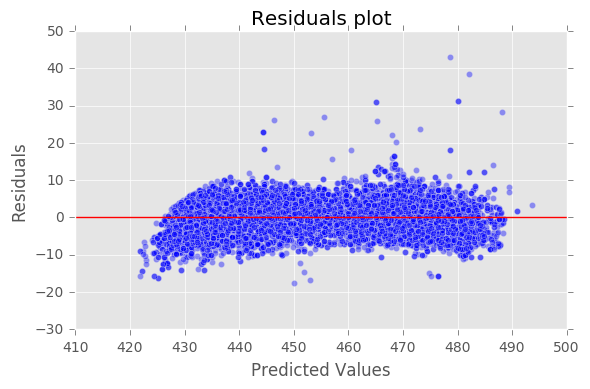

In [12]:
# Let's run the model on the test data set for the purpose of residual plot analysis:
predicted_y_test = pipeline.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_y_test))
resids = predicted_y_test.reshape(len(y_test), 1) - y_test

plt.clf()
plt.scatter(predicted_y_test, resids, alpha=0.4)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals plot')
plt.hlines(y=0, xmin=410, xmax=500, color='red')
plt.tight_layout()
plt.xlim([410, 500])
plt.show()

We do not see any big deviations from normality judging from the plot above. However, notice that for the Predicted Values at the extreme ends (between 420 and 430 as well as 480 and 490), the model seems to be under-predicting the target values more than over-predicting. 
In general, the residuals seem to be proportionately distributed around zero, so no big violation of constant variance (homoskedasticity). However, there are a few outliers. Decision Tree models might be better suited for this data due to the presence of some non-linearity, as we'll see later.

We can plot a histogram to see the proportion of data within 2 RMSE, which should be around 95% for a normally distributed data:

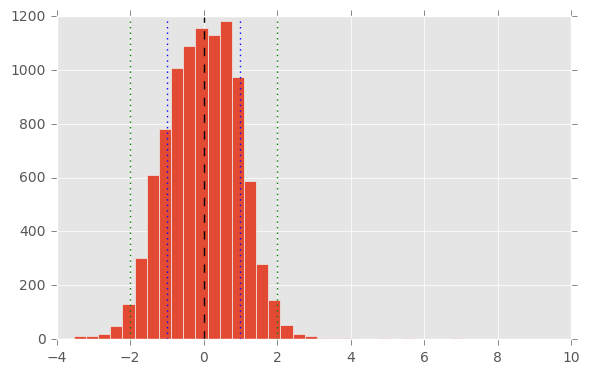

The proportion of test data predictions within 2 RMSE: 0.97


In [13]:
within_rmse = resids / rmse_test
plt.clf()
within_rmse.hist(bins=40)
plt.ylim([0, 1200])
plt.tight_layout()
plt.title('')
plt.vlines(0, ymin=0, ymax=1196, colors='k', linestyles='dashed')
plt.vlines(1, ymin=0, ymax=1196, colors='b', linestyles='dotted')
plt.vlines(-1, ymin=0, ymax=1196, colors='b', linestyles='dotted')
plt.vlines(2, ymin=0, ymax=1196, colors='g', linestyles='dotted')
plt.vlines(-2, ymin=0, ymax=1196, colors='g', linestyles='dotted')
plt.show()

count1 = within_rmse.where((within_rmse < -2) | (within_rmse > 2)).count()
print('The proportion of test data predictions within 2 RMSE: {:.2f}'.format((len(y_test) - int(count1)) / len(y_test)))

97% of the predicted values are within 2 RMSE. We can see some skewness on the graph, which could also be a cause for concern.

Now, let's run a Ridge Regression (regression with $l_2$-regularization) and a Lasso Regression ($l_1$-regularization) to compare their performance to the above model. These two models require us to pre-specify the regularization parameter, $alpha$. I use `GridSearchCV` from the `sklearn` module to do an exaustive search and find the best value of the parameter $alpha$ for the model using 3 folds (for cross-validation) and 7 different options for the parameter value.

First, to make things easier, I define a function that will train a model and print out the model performance evaluation. I make use of nested cross-validation with 3 inner loops and 5 outer loops for model performance comparison. Nested cross-validation is advised as best practice for model performance comparison. The inner loop finds the best parameters using cross-validated grid search and the outer loop evaluates the performance of model with the best parameters. This gives a more reliable estimate of model performance on unseen data.

In [14]:

def nested_cv(estimator, param_names, param_vals=list(np.logspace(-4, 2, 7)), y_train=y_train):
    ''' Performs model performance evaluation using a 5x3 nested cross-validation. 
        Inputs:
            estimator: estimator, model instance
            param_names: a list of hyperparameter names to be tuned by grid search
            param_vals: a list of hyperparameter values to use for tuning, default(list(np.logspace(-4, 2, 7)))
            y_train: the target variable. A DataFrame or ndarray object
        Returns:
            nested_cv_RMSE value: a float
    '''
    if not isinstance(param_vals[0], list):
        temp_pv = []
        temp_pv.append(param_vals)
    else:
        temp_pv = param_vals
    params = {name: val for name, val in zip(param_names, temp_pv)} 
    # inner loop:
    grid_search = GridSearchCV(estimator=estimator, param_grid=params,
                               scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    # outer loop:
    MSEs = cross_val_score(grid_search, X=X_train, y=y_train, cv=5, n_jobs=-1)
    nested_cv_RMSE = np.sqrt(-MSEs.mean())
    return nested_cv_RMSE

In [15]:
print('Ridge Regression:')
pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(random_state=1))])
tune_param_ridge = ['ridge__alpha']

rmse_ncv_ridge = nested_cv(pipe_ridge, tune_param_ridge)
print('RMSE: {:.3f}'.format(rmse_ncv_ridge))

Ridge Regression:
RMSE: 4.548


In [16]:
print('Lasso Regression:')
pipe_lasso = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(random_state=2))])
tune_param_lasso = ['lasso__alpha']

rmse_ncv_lasso = nested_cv(pipe_lasso, tune_param_lasso)
print('RMSE: {:.3f}'.format(rmse_ncv_lasso))

Lasso Regression:
RMSE: 4.548


As we can see, the performance here is similar to the performance of the OLS model without any regularization. Both, the lasso and ridge regression perform equally with cross-validated lowest RMSE values of $4.548$. If we want to see the best parameters we'll have to do another grid search (just the inner loop of the nested-crossvalidation):


In [17]:
def tune_hyperparams(estimator, param_names, param_vals=list(np.logspace(-4, 2, 7)), y_train=y_train):
    ''' Performs a grid search to find the best hyperparameters for a model.
        Inputs:
            estimator: estimator, model instance
            param_names: a list of hyperparameter names to be tuned by grid search
            param_vals: a list of hyperparameter values to use for tuning, default(list(np.logspace(-4, 2, 7)))
            y_train: the target variable. A DataFrame or ndarray object
        Returns:
            nested_cv_RMSE value: a float
    '''
    if not isinstance(param_vals[0], list):
        temp_pv = []
        temp_pv.append(param_vals)
    else:
        temp_pv = param_vals
    params = {name: val for name, val in zip(param_names, temp_pv)}
    grid_search = GridSearchCV(estimator, params, scoring='neg_mean_squared_error',
                               n_jobs=-1, cv=3)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

In [18]:
best_params_ridge = tune_hyperparams(pipe_ridge, tune_param_ridge)
best_params_lasso = tune_hyperparams(pipe_lasso, tune_param_lasso)

print('Ridge Regression best hyperparameter: ', best_params_ridge)
print('Lasso Regression best hyperparameter: ', best_params_lasso)

Ridge Regression best hyperparameter:  {'ridge__alpha': 0.10000000000000001}
Lasso Regression best hyperparameter:  {'lasso__alpha': 0.0001}


#### Decision Tree and Random Forest models

Since a Decision Tree model is better for non-linear data, let's see how it performs.
An advantage of Decision Tree models is that we don't need to transform the features, so no need for standardization here.

In [19]:
dt = DecisionTreeRegressor(random_state=0, max_depth=3)
score = np.sqrt(-cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error', cv=10))
print('Decision Tree model:')
print('RMSE: {:.3f}'.format(score.mean()))

Decision Tree model:
RMSE: 5.118


Compared to RMSE's of OSL, Ridge and Lasso regression models $(4.547$, $4.548$ and $4.548)$ the Decision Tree model above has a worse performance.

We can visualize the tree using the `export_graphviz()` function imported from the `sklearn.tree` module to save a `.dot` file and then convert it to `.png` using `dot -Tpng dt.dot -o dt.png` in the command line in the directory where the file is saved.

In [20]:
dt.fit(X_train, y_train)
export_graphviz(dt, out_file="dt.dot", feature_names=X_train.columns, filled=1, rotate=1)

![Decision Tree Graph](./dt.png)

We see that mostly the $AT$ feature is used to split the tree into child nodes. At two of the nodes, the model is using the $V$ feature. This is not surprising and fits the impression we got from the scatter plots shown earlier that only these two variables seem to have a linear relationsihp with __Power Output__. 
We can plot the the feature importances using the `feature_importances_` attribute of tree based models in `sklearn`:

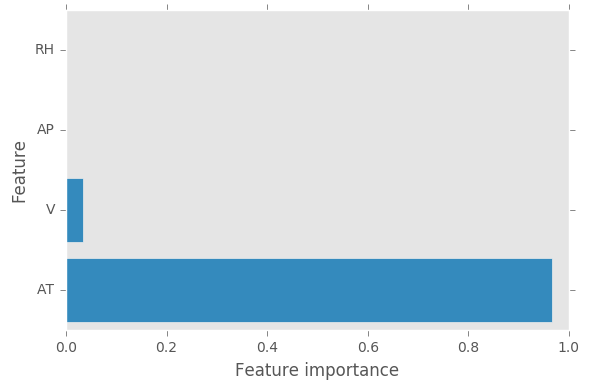

In [21]:
def feature_importances(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.grid()
    plt.show()

feature_importances(dt)

This graph confirms our conclusion above. $AT$ is the star in this movie.

The model has a max depth of 3, as we can see from it's graphical representation. Let's try to tune the maximum depth of the tree using the `nested_cv()` function I defined earlier. Below I try the values 2, 3 and 5 as the max_depth parameter value and print out the RMSE:

In [22]:
print('Decision Tree model (nested CV):')
dt = DecisionTreeRegressor(random_state=0)
tune_param_dt = ['max_depth']
param_vals_dt = [2, 3, 5]

rmse_ncv_dt = nested_cv(dt, tune_param_dt, param_vals_dt)
print('RMSE: {:.3f}'.format(rmse_ncv_dt))

Decision Tree model (nested CV):
RMSE: 4.322


So, a tuned Decision Tree model performs a bit better (RMSE = $4.322$) than the Linear Regression models before it.
Let's see the what `max_depth` value gives the best performance:

In [23]:
best_params_dt = tune_hyperparams(dt, tune_param_dt, param_vals_dt)
print('Decision Tree best hyperparameter: ', best_params_dt)

Decision Tree best hyperparameter:  {'max_depth': 5}


Looks like a tree with maximum depth of 5 will give the best performance (typically, the higher that number the better the model fits the training data). A Decision Tree model will tend to overfit the training data and might not perform so well with unseen data (this is also called a high variance problem).

We can try a Random Forest model, which is an ensemble of Decision Tree models and as such has better generalization potential.

In [24]:
forest = RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=1,
                               warm_start=1, oob_score=1, max_depth=8)
score = np.sqrt(-cross_val_score(forest, X_train, y_train.values.ravel(), scoring='neg_mean_squared_error', cv=5))
print('Random Forest Model:')
print('RMSE: {:.3f}'.format(score.mean()))

forest.fit(X_train, y_train.values.ravel())
predicted_y_test = forest.predict(X_test)

Random Forest Model:
RMSE: 3.313


With max depth equal to 8 and 30 decision trees in the ensemble, the Random Forest model is better than just a single Decision Tree.

Let's try to tune the $n\_estimators$ and $max\_depth$ parameters:

In [25]:
print('Random Forest model (nested CV):')
tune_param_forest = ['n_estimators', 'max_depth']
param_vals_forest = [[30, 60, 90], [3, 6, 10]]

rmse_ncv_forest = nested_cv(forest, tune_param_forest, param_vals_forest, y_train=y_train.values.ravel())
print('RMSE: {:.3f}'.format(rmse_ncv_forest))

Random Forest model (nested CV):
RMSE: 2.694


We can see that the tuned Random Forest model above performs better than the other models. We are able to get the RMSE value down to $2.694$.

Let's see the best hyperparameter values and how the model performs on the unseen test set:

In [26]:
params = {name: val for name, val in zip(tune_param_forest, param_vals_forest)}
grid_search = GridSearchCV(forest, params, scoring='neg_mean_squared_error',
                           n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train.values.ravel())
predicted_y_test = grid_search.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, predicted_y_test))
r2_test = r2_score(y_test, predicted_y_test)
adj_r2_test = adjusted_r2(r2=r2_test, n=X_test.shape[0], p=X_test.shape[1])

print('Decision Tree best hyperparameters: ', grid_search.best_params_)
print('\n', 'Model performance on unseen data:')
print('The test dataset RMSE is: {:.3f}'.format(rmse_test))
print('The test dataset R-Squared value is: {:.3f}'.format(r2_test))
print('The test dataset Adjusted R-Squared value is {:.3f}'.format(adj_r2_test))

Decision Tree best hyperparameters:  {'max_depth': 10, 'n_estimators': 90}

 Model performance on unseen data:
The test dataset RMSE is: 2.702
The test dataset R-Squared value is: 0.975
The test dataset Adjusted R-Squared value is 0.975


The performance of this model on the unseen test data is good, with an Adjusted R-Squared value of almost $0.98$ and RMSE value just slightly above the RMSE value for the training dataset.

We can plot the feature importances as judged by the Random Forest model:

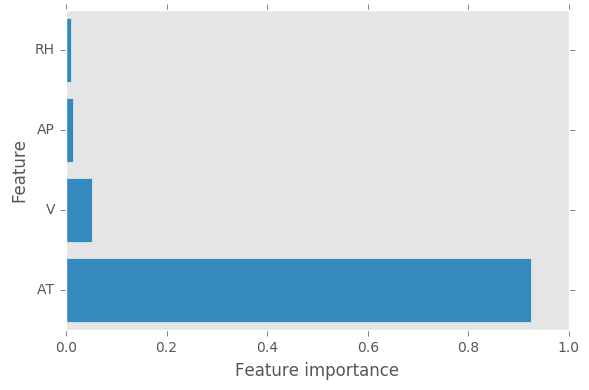

In [27]:
feature_importances(grid_search.best_estimator_)

Unsurprisingly, __Atmospheric Temperature__ is the most important feature, outshining the other features by quite a lot. 

### Conclusion

So, the best model we've seen is the Random Forest model, with the lowest nested cross-validated RMSE as we can see in the table below:

In [31]:
print('Model          ', 'RMSE')
print('-' * 26)
print('OLS            ', '{:.4f}'.format(rmse_cv.mean()))
print('Ridge          ', '{:.5f}'.format(rmse_ncv_ridge))
print('Lasso          ', '{:.5f}'.format(rmse_ncv_lasso))
print('Decision Tree  ', '{:.4f}'.format(rmse_ncv_dt))
print('Random Forest  ', '{:.4f}'.format(rmse_ncv_forest))

Model           RMSE
--------------------------
OLS             4.5474
Ridge           4.54783
Lasso           4.54784
Decision Tree   4.3215
Random Forest   2.6945


The performance of the Random Forest model was similar when faced with unseen test data:

In [29]:
print('Random Forest RMSE (test dataset) {:.4f}'.format(rmse_test))

Random Forest RMSE (test dataset) 2.7023
